# **Bài thực hành 2. TỐI ƯU MÔ HÌNH MẠNG NEURAL**

## A. KHỞI ĐỘNG



*   Tham số (parameter): Trọng số (Weights), Độ chệch (Biases).
*   Siêu tham số(hyperparameter): Learning rate, Activation function, Batch size, epochs.
* Phương pháp tối ưu: Gradient Descent, Stochastic Gradient Descent, RMSProp, Adam, AdamW.





##  B. BỘ DỮ LIỆU

### Load dữ liệu

In [ ]:
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
import torch
import torchvision
from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torchsummary import summary
from tqdm import tqdm
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix
import seaborn as sns

# Config
num_epochs = 20
learning_rate = 0.01
learning_rate_adam = 1e-5
lambda_ = 0.01
momentum = 0.5
momentum_g = 0.9
log_interval = 10
random_seed = 1

torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [ ]:

train_loader = torch.utils.data.DataLoader(FashionMNIST('/files/', train=True, download=True,\
                        transform=transforms.Compose([\
                            transforms.ToTensor(),\
                            transforms.Normalize((0.1307,), (0.3081,))\
                        ])), batch_size = 64, shuffle=True)

trainset = train_loader.dataset

len(trainset)

60000

In [ ]:
test_loader = torch.utils.data.DataLoader(FashionMNIST('/files/', train=False, download=True,\
                        transform=transforms.Compose([\
                            transforms.ToTensor(),\
                            transforms.Normalize((0.1307,), (0.3081,))\
                        ])), batch_size = 1, shuffle=True)

testset = test_loader.dataset

len(testset)

10000

### Khảo sát dữ liệu

In [ ]:
print("Numbers class: ", len(trainset.classes))
trainset.classes

Numbers class:  10


['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [ ]:
print("Size image train: ", trainset[0][0].size())
print("Size image test: ", testset[0][0].size())

Size image train:  torch.Size([1, 28, 28])
Size image test:  torch.Size([1, 28, 28])


### Trực quan hóa

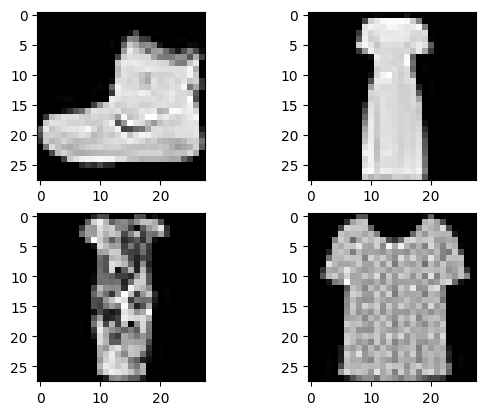

In [ ]:
plt.subplot(2, 2, 1)
plt.imshow(trainset.data[0], cmap='gray')

plt.subplot(2, 2, 2)
plt.imshow(trainset.data[50], cmap='gray')

plt.subplot(2, 2, 3)
plt.imshow(testset.data[100], cmap='gray')

plt.subplot(2, 2, 4)
plt.imshow(testset.data[1000], cmap='gray')

plt.show()

##  C. XÂY DỰNG VÀ HUẤN LUYỆN MÔ HÌNH - HÀM KÍCH HOẠT

* Một vài hàm kích hoạt: Sigmoid, Tanh, Relu, ELU, Softmax.





In [ ]:
class ModelC (nn.Module):
     def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.flatten = nn.Flatten(start_dim=1)
        self.linear1 = nn.Linear(in_features=784, out_features=512)
        self.linear2 =  nn.Linear(in_features=512, out_features=256)
        self.linear3 = nn.Linear(in_features=256, out_features=10)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax()

     def forward(self, x: torch.Tensor):
        x = self.flatten(x)
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.linear3(x)
        x = self.softmax(x)
        return x

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ModelC().to(device)

summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
              ReLU-3                  [-1, 512]               0
            Linear-4                  [-1, 256]         131,328
              ReLU-5                  [-1, 256]               0
            Linear-6                   [-1, 10]           2,570
           Softmax-7                   [-1, 10]               0
Total params: 535,818
Trainable params: 535,818
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 2.04
Estimated Total Size (MB): 2.06
----------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [ ]:
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = momentum)

loss_fn = nn.CrossEntropyLoss()

list_loss = []
list_accuracy = []

for epoch in range(num_epochs):
    epoch_loss = 0.0
    epoch_acc = 0.0

    with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
        for i, (images, labels) in enumerate(train_loader):
            # forward backward, update
            images = images.to(device)
            labels = labels.to(device)
            # Forward pass
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            acc = (torch.max(outputs, dim=1)[1] == labels).sum().item() / labels.size(0)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            epoch_acc += acc

            pbar.set_postfix({'Loss': f'{epoch_loss / (i+1):.4f}', 'Accuracy': f'{epoch_acc / (i+1):.4f}'})
            pbar.update()

    epoch_loss /= len(train_loader)
    epoch_acc /= len(train_loader)
    list_loss.append(epoch_loss)
    list_accuracy.append(epoch_acc)


Epoch 20/20: 100%|██████████| 938/938 [00:18<00:00, 51.15batch/s, Loss=1.6305, Accuracy=0.8339]


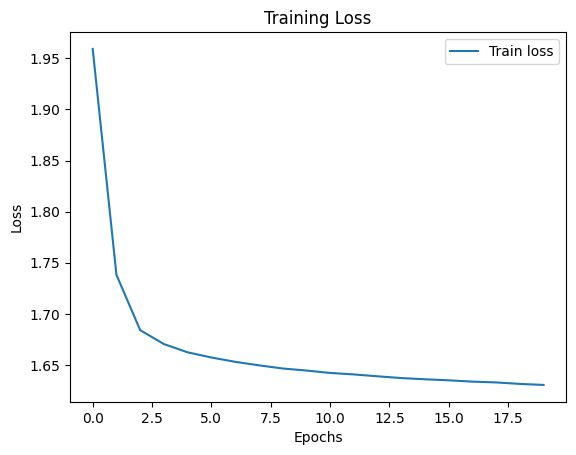

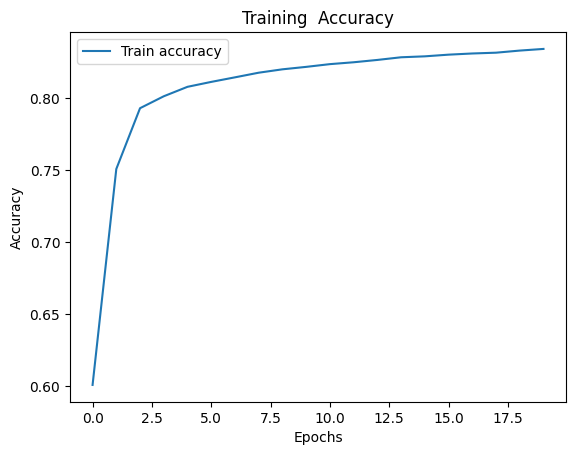

In [ ]:
epochs = range(num_epochs)

plt.plot(epochs, list_loss, label='Train loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.plot(epochs, list_accuracy, label='Train accuracy')
plt.title('Training  Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Evaluation functions

In [ ]:
def predict(model, test_loader):
    model.eval()
    y_pred = []
    y_true = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(labels.cpu().numpy())
    return y_pred, y_true

In [ ]:
def compute_score(y_pred: list, y_true: list):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=1)
    precision = precision_score(y_true, y_pred, average='macro', zero_division=1)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=1)

    return acc, f1, precision, recall

In [ ]:
def classification_labels(y_pred: list, y_true: list, num_classes=10):
    y_true = torch.tensor(y_true)
    y_pred = torch.tensor(y_pred)

    conf_matrix = torch.zeros((num_classes, num_classes), dtype=torch.int)
    for t, p in zip(y_true.view(-1), y_pred.view(-1)):
        conf_matrix[t.long(), p.long()] += 1

    accuracy = torch.diag(conf_matrix) / conf_matrix.sum(1)
    precision = torch.diag(conf_matrix) / conf_matrix.sum(0)
    recall = torch.diag(conf_matrix) / conf_matrix.sum(1)
    f1 = 2 * (precision * recall) / (precision + recall)

    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

    return metrics

In [ ]:
def show_confusion_matrix(y_pred: list, y_true: list):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='viridis')
    plt.ylabel('Labels')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

### Đánh giá mô hình

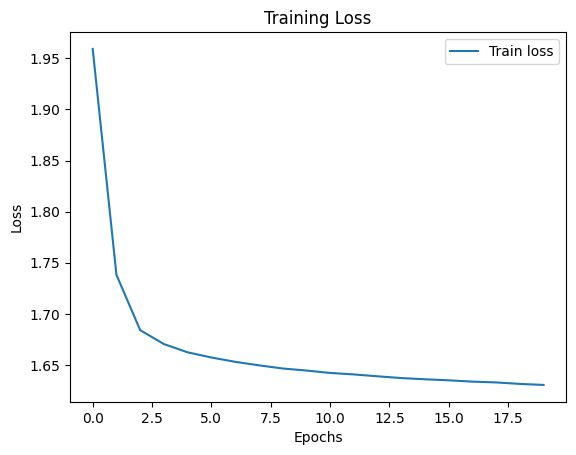

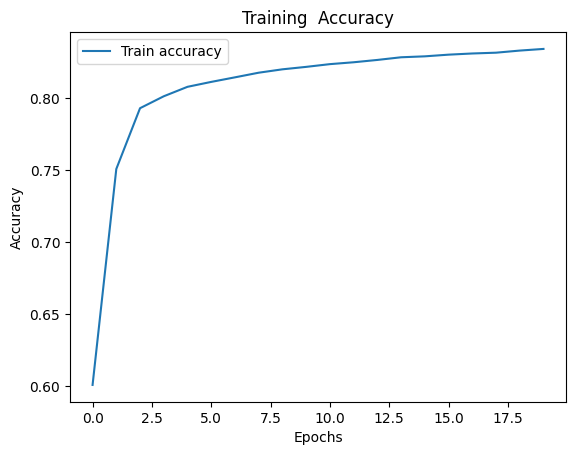

In [ ]:
epochs = range(num_epochs)

plt.plot(epochs, list_loss, label='Train loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.plot(epochs, list_accuracy, label='Train accuracy')
plt.title('Training  Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
y_pred, y_true = predict(model, test_loader)

In [ ]:
acc, f1, precision, recall = compute_score(y_pred, y_true)
print("Accuracy: {:.2f}".format(acc), end=" | ")
print("F1 Score: {:.2f}".format(f1), end=" | ")
print("Precision: {:.2f}".format(precision), end=" | ")
print("Recall: {:.2f}".format(recall))

Accuracy: 0.82 | F1 Score: 0.78 | Precision: 0.85 | Recall: 0.82


In [ ]:
metrics = classification_labels(y_pred, y_true)
print(f'{"Class":<5} {"F1-score":<10} {"Accuracy":<10} {"Precision":<10} {"Recall":<10}')

for i in range(len(metrics['f1'])):
  print(f'{i:<5} {metrics["f1"][i].item():<10.4f} {metrics["accuracy"][i].item():<10.4f} {metrics["precision"][i].item():<10.4f} {metrics["recall"][i].item():<10.4f}')

Class F1-score   Accuracy   Precision  Recall    
0     0.7926     0.8980     0.7093     0.8980    
1     0.9711     0.9570     0.9856     0.9570    
2     0.7264     0.7900     0.6723     0.7900    
3     0.8546     0.8990     0.8143     0.8990    
4     0.7028     0.8550     0.5967     0.8550    
5     0.9498     0.9370     0.9630     0.9370    
6     nan        0.0000     nan        0.0000    
7     0.9299     0.9610     0.9007     0.9610    
8     0.9429     0.9660     0.9209     0.9660    
9     0.9480     0.9300     0.9667     0.9300    


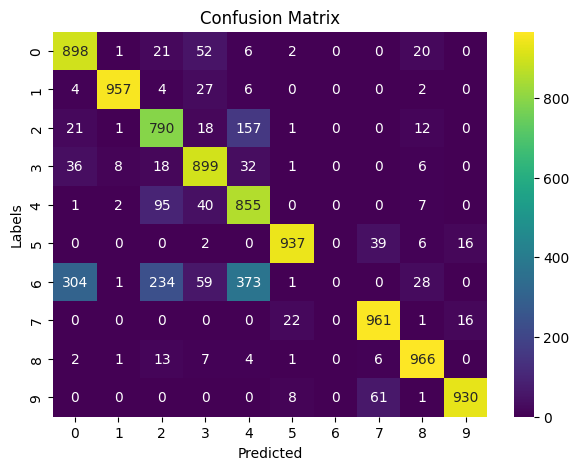

In [ ]:
show_confusion_matrix(y_pred, y_true)

**Nhận Xét:** Có thể mô hình cho kết quả khá cao ở các class ngoại trừ class 6 dự đoán sai ở tất cả các điểm dữ liệu. Có thể thấy mô hình vẫn còn chưa học được đặc điểm của nhãn 6.

## D. HÀM MẤT MÁT

* Một vài hàm mất mát: Cross-Entropy Loss , Binary Cross-Entropy Loss.

## E. CHUẨN HÓA MÔ HÌNH

### **Chuẩn hoá L2 với $\lambda = 0.01$**

In [ ]:
model = ModelC().to(device)

In [ ]:
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = momentum)

In [ ]:
def l2_regularization(model, lambda_):
    l2_reg = 0
    for param in model.parameters():
        l2_reg += torch.norm(param)
    return lambda_ * l2_reg

In [ ]:
loss_fn = nn.CrossEntropyLoss()

list_loss = []
list_accuracy = []

for epoch in range(num_epochs):
    epoch_loss = 0.0
    epoch_acc = 0.0

    with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
        for i, (images, labels) in enumerate(train_loader):
            # forward backward, update
            images = images.to(device)
            labels = labels.to(device)
            # Forward pass
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            acc = (torch.max(outputs, dim=1)[1] == labels).sum().item() / labels.size(0)
            # Add L2 regularization term
            l2_reg = l2_regularization(model, lambda_)
            loss += l2_reg

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            epoch_acc += acc

            pbar.set_postfix({'Loss': f'{epoch_loss / (i+1):.4f}', 'Accuracy': f'{epoch_acc / (i+1):.4f}'})
            pbar.update()

    epoch_loss /= len(train_loader)
    epoch_acc /= len(train_loader)
    list_loss.append(epoch_loss)
    list_accuracy.append(epoch_acc)


Epoch 1/20:   0%|          | 0/938 [00:00<?, ?batch/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Epoch 20/20: 100%|██████████| 938/938 [00:20<00:00, 45.00batch/s, Loss=1.8228, Accuracy=0.8557]


### Đánh giá mô hình

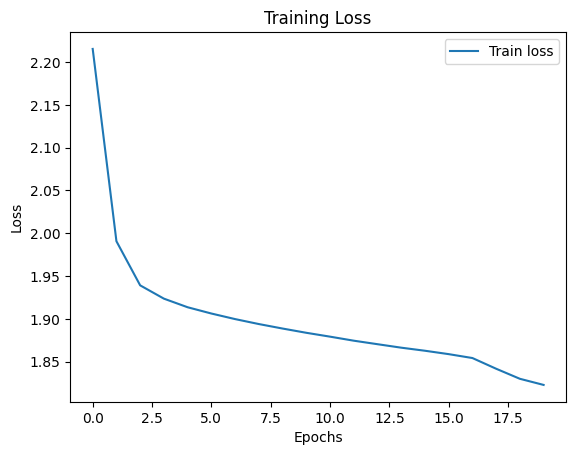

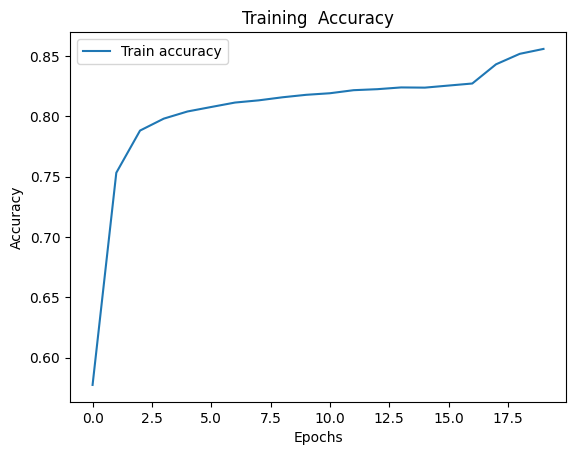

In [ ]:
epochs = range(num_epochs)

plt.plot(epochs, list_loss, label='Train loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.plot(epochs, list_accuracy, label='Train accuracy')
plt.title('Training  Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
y_pred, y_true = predict(model, test_loader)

In [ ]:
acc, f1, precision, recall = compute_score(y_pred, y_true)
print("Accuracy: {:.2f}".format(acc), end=" | ")
print("F1 Score: {:.2f}".format(f1), end=" | ")
print("Precision: {:.2f}".format(precision), end=" | ")
print("Recall: {:.2f}".format(recall))

Accuracy: 0.84 | F1 Score: 0.84 | Precision: 0.84 | Recall: 0.84


In [ ]:
metrics = classification_labels(y_pred, y_true)
print(f'{"Class":<5} {"F1-score":<10} {"Accuracy":<10} {"Precision":<10} {"Recall":<10}')

for i in range(len(metrics['f1'])):
  print(f'{i:<5} {metrics["f1"][i].item():<10.4f} {metrics["accuracy"][i].item():<10.4f} {metrics["precision"][i].item():<10.4f} {metrics["recall"][i].item():<10.4f}')

Class F1-score   Accuracy   Precision  Recall    
0     0.7970     0.8400     0.7581     0.8400    
1     0.9697     0.9590     0.9806     0.9590    
2     0.7396     0.7200     0.7603     0.7200    
3     0.8521     0.8610     0.8433     0.8610    
4     0.7528     0.8100     0.7031     0.8100    
5     0.9419     0.9320     0.9520     0.9320    
6     0.5138     0.4460     0.6060     0.4460    
7     0.9216     0.9410     0.9031     0.9410    
8     0.9400     0.9630     0.9180     0.9630    
9     0.9467     0.9410     0.9524     0.9410    


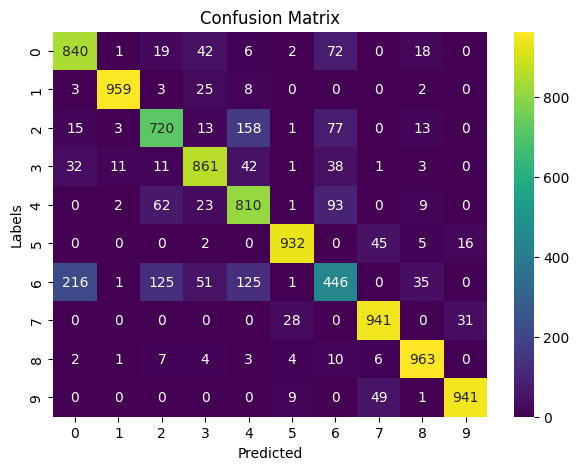

In [ ]:
show_confusion_matrix(y_pred, y_true)

**Nhận Xét:** Khi chuẩn hóa L2 cho các tham số với lamda_ = 0.01 khả năng học của mô hình đã cái thiện đáng kể so với ở câu C. Nhãn 6 đã cải thiện với Acc = 0.4460%.

## F. Khởi tạo tham số

* Chuẩn hóa L1 (L1 Normalization):
Chuẩn hóa L1 của một vector x = [x₁, x₂, ..., xₙ] được định nghĩa là:
xₗ₁ = x / ||x||₁ = x / ∑|xᵢ|,\
trong đó, ||x||₁ = ∑|xᵢ| là chuẩn L1 của vector x.

* Chuẩn hóa L2 (L2 Normalization):
Chuẩn hóa L2 của một vector x = [x₁, x₂, ..., xₙ] được định nghĩa là:\
xₗ₂ = x / ||x||₂ = x / √∑xᵢ²,
trong đó, ||x||₂ = √∑xᵢ² là chuẩn L2 của vector x.

### Khởi tạo W và b theo phương pháp Ones

In [ ]:
class ModelF1 (nn.Module):
     def __init__(self, *args, **kwargs) -> None:
        super(ModelF1, self).__init__()
        self.flatten = nn.Flatten(start_dim=1)
        self.linear1 = nn.Linear(in_features=784, out_features=512)
        self.linear2 =  nn.Linear(in_features=512, out_features=256)
        self.linear3 = nn.Linear(in_features=256, out_features=10)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

        nn.init.ones_(self.linear1.weight)
        nn.init.ones_(self.linear1.bias)
        nn.init.ones_(self.linear2.weight)
        nn.init.ones_(self.linear2.bias)
        nn.init.ones_(self.linear3.weight)
        nn.init.ones_(self.linear3.bias)

     def forward(self, x: torch.Tensor):
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        x = self.softmax(x)
        return x

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ModelF1().to(device)

summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
              ReLU-3                  [-1, 512]               0
            Linear-4                  [-1, 256]         131,328
              ReLU-5                  [-1, 256]               0
            Linear-6                   [-1, 10]           2,570
           Softmax-7                   [-1, 10]               0
Total params: 535,818
Trainable params: 535,818
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 2.04
Estimated Total Size (MB): 2.06
----------------------------------------------------------------


In [ ]:
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = momentum)

In [ ]:
loss_fn = nn.CrossEntropyLoss()

list_loss = []
list_accuracy = []

for epoch in range(num_epochs):
    epoch_loss = 0.0
    epoch_acc = 0.0

    with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
        for i, (images, labels) in enumerate(train_loader):
            # forward backward, update
            images = images.to(device)
            labels = labels.to(device)
            # Forward pass
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            acc = (torch.max(outputs, dim=1)[1] == labels).sum().item() / labels.size(0)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            epoch_acc += acc

            pbar.set_postfix({'Loss': f'{epoch_loss / (i+1):.4f}', 'Accuracy': f'{epoch_acc / (i+1):.4f}'})
            pbar.update()

    epoch_loss /= len(train_loader)
    epoch_acc /= len(train_loader)
    list_loss.append(epoch_loss)
    list_accuracy.append(epoch_acc)


Epoch 20/20: 100%|██████████| 938/938 [00:18<00:00, 49.81batch/s, Loss=2.3611, Accuracy=0.1000]


#### Đánh giá mô hình

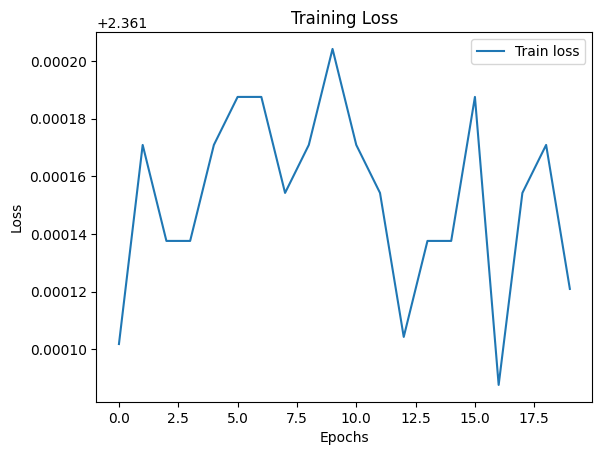

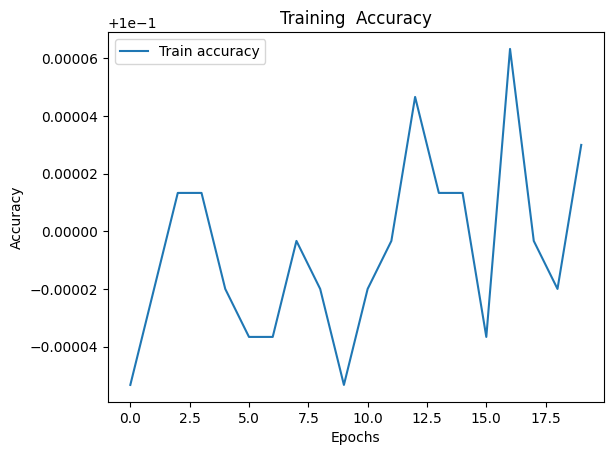

In [ ]:
epochs = range(num_epochs)

plt.plot(epochs, list_loss, label='Train loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.plot(epochs, list_accuracy, label='Train accuracy')
plt.title('Training  Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
y_pred, y_true = predict(model, test_loader)

In [ ]:
acc, f1, precision, recall = compute_score(y_pred, y_true)
print("Accuracy: {:.2f}".format(acc), end=" | ")
print("F1 Score: {:.2f}".format(f1), end=" | ")
print("Precision: {:.2f}".format(precision), end=" | ")
print("Recall: {:.2f}".format(recall))

Accuracy: 0.10 | F1 Score: 0.02 | Precision: 0.91 | Recall: 0.10


In [ ]:
metrics = classification_labels(y_pred, y_true)
print(f'{"Class":<5} {"F1-score":<10} {"Accuracy":<10} {"Precision":<10} {"Recall":<10}')

for i in range(len(metrics['f1'])):
  print(f'{i:<5} {metrics["f1"][i].item():<10.4f} {metrics["accuracy"][i].item():<10.4f} {metrics["precision"][i].item():<10.4f} {metrics["recall"][i].item():<10.4f}')

Class F1-score   Accuracy   Precision  Recall    
0     nan        0.0000     nan        0.0000    
1     nan        0.0000     nan        0.0000    
2     nan        0.0000     nan        0.0000    
3     nan        0.0000     nan        0.0000    
4     0.1818     1.0000     0.1000     1.0000    
5     nan        0.0000     nan        0.0000    
6     nan        0.0000     nan        0.0000    
7     nan        0.0000     nan        0.0000    
8     nan        0.0000     nan        0.0000    
9     nan        0.0000     nan        0.0000    


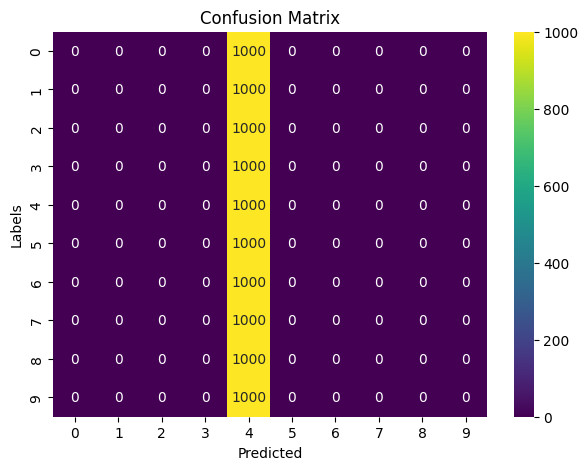

In [ ]:
show_confusion_matrix(y_pred, y_true)

**Nhận Xét:**
* Khi khởi tạo W và b theo ones có thể thấy mô hình dự đoán ra toàn bộ là nhãn 4. Điều này có thể cho thấy mô hình không học được đặc trưng của các class này và có thể bị ảnh hưởng bởi việc khởi tạo W và b theo Ones.
* Ngoài ra dựa vào training loss và Acc có thể thấy nó không ổn định qua từng epochs.
* Có thể thấy phương pháp Ones không phù hợp với bài toán này.


### Khởi tạo W theo phương pháp Glorot Uniform và b theo phương pháp Zeros

In [ ]:
class ModelF2 (nn.Module):
     def __init__(self, *args, **kwargs) -> None:
        super(ModelF2, self).__init__()
        self.flatten = nn.Flatten(start_dim=1)
        self.linear1 = nn.Linear(in_features=784, out_features=512)
        self.linear2 =  nn.Linear(in_features=512, out_features=256)
        self.linear3 = nn.Linear(in_features=256, out_features=10)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

        nn.init.xavier_uniform_(self.linear1.weight)
        nn.init.zeros_(self.linear1.bias)
        nn.init.xavier_uniform_(self.linear2.weight)
        nn.init.zeros_(self.linear2.bias)
        nn.init.xavier_uniform_(self.linear3.weight)
        nn.init.zeros_(self.linear3.bias)

     def forward(self, x: torch.Tensor):
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        x = self.softmax(x)
        return x

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ModelF2().to(device)

summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
              ReLU-3                  [-1, 512]               0
            Linear-4                  [-1, 256]         131,328
              ReLU-5                  [-1, 256]               0
            Linear-6                   [-1, 10]           2,570
           Softmax-7                   [-1, 10]               0
Total params: 535,818
Trainable params: 535,818
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 2.04
Estimated Total Size (MB): 2.06
----------------------------------------------------------------


In [ ]:
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = momentum)

In [ ]:
loss_fn = nn.CrossEntropyLoss()

list_loss = []
list_accuracy = []

for epoch in range(num_epochs):
    epoch_loss = 0.0
    epoch_acc = 0.0

    with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
        for i, (images, labels) in enumerate(train_loader):
            # forward backward, update
            images = images.to(device)
            labels = labels.to(device)
            # Forward pass
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            acc = (torch.max(outputs, dim=1)[1] == labels).sum().item() / labels.size(0)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            epoch_acc += acc

            pbar.set_postfix({'Loss': f'{epoch_loss / (i+1):.4f}', 'Accuracy': f'{epoch_acc / (i+1):.4f}'})
            pbar.update()

    epoch_loss /= len(train_loader)
    epoch_acc /= len(train_loader)
    list_loss.append(epoch_loss)
    list_accuracy.append(epoch_acc)

Epoch 20/20: 100%|██████████| 938/938 [00:18<00:00, 49.73batch/s, Loss=1.5713, Accuracy=0.8951]


#### Đánh giá mô hình

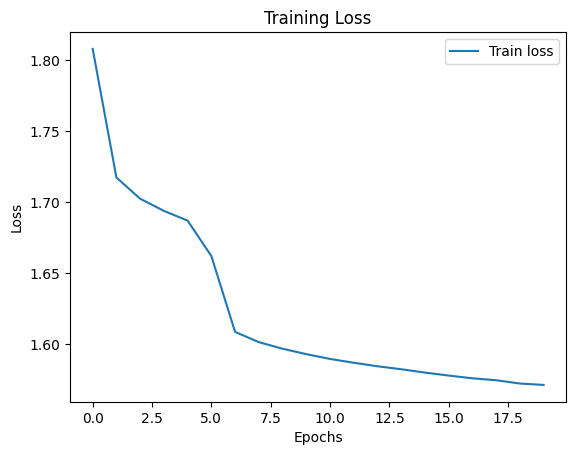

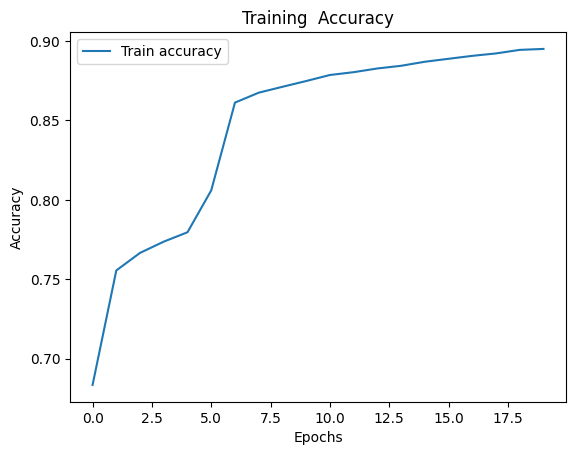

In [ ]:
epochs = range(num_epochs)

plt.plot(epochs, list_loss, label='Train loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.plot(epochs, list_accuracy, label='Train accuracy')
plt.title('Training  Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
y_pred, y_true = predict(model, test_loader)

In [ ]:
acc, f1, precision, recall = compute_score(y_pred, y_true)
print("Accuracy: {:.2f}".format(acc), end=" | ")
print("F1 Score: {:.2f}".format(f1), end=" | ")
print("Precision: {:.2f}".format(precision), end=" | ")
print("Recall: {:.2f}".format(recall))

Accuracy: 0.87 | F1 Score: 0.87 | Precision: 0.87 | Recall: 0.87


In [ ]:
metrics = classification_labels(y_pred, y_true)
print(f'{"Class":<5} {"F1-score":<10} {"Accuracy":<10} {"Precision":<10} {"Recall":<10}')

for i in range(len(metrics['f1'])):
  print(f'{i:<5} {metrics["f1"][i].item():<10.4f} {metrics["accuracy"][i].item():<10.4f} {metrics["precision"][i].item():<10.4f} {metrics["recall"][i].item():<10.4f}')

Class F1-score   Accuracy   Precision  Recall    
0     0.8254     0.8510     0.8013     0.8510    
1     0.9743     0.9650     0.9837     0.9650    
2     0.7848     0.8060     0.7647     0.8060    
3     0.8684     0.8710     0.8658     0.8710    
4     0.7779     0.7620     0.7946     0.7620    
5     0.9540     0.9430     0.9652     0.9430    
6     0.6600     0.6260     0.6979     0.6260    
7     0.9337     0.9500     0.9179     0.9500    
8     0.9558     0.9730     0.9392     0.9730    
9     0.9513     0.9480     0.9547     0.9480    


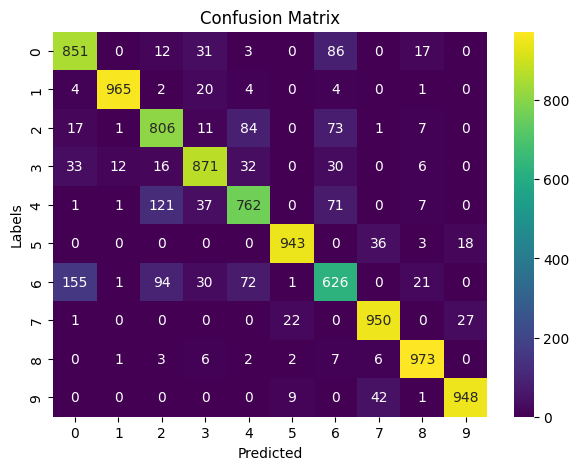

In [ ]:
show_confusion_matrix(y_pred, y_true)

**Nhận Xét:**

*   Với việc khởi tạo tham số W theo phương pháp Glorot Uniform và b theo phương pháp Zeros so với phương pháp Ones ở trên có thể thấy cho kết quả vượt trội và đạt kết quả cao hơn tất cả các phương pháp thử nghiệm ở trên.
*   Điều này cho thấy tầm quan trọng của việc khởi tạo tham số mô hình một cách hợp lý để nâng cao hiệu suất của mô hình.



## G. CÁC THUẬT TOÁN TỐI ƯU

* Phương pháp tối ưu: Gradient Descent, Stochastic Gradient Descent, RMSProp, Adam, AdamW.

### Hàm tối ưu RMSProp với learning rate = 0.01 và momentum = 0.9

In [ ]:
model = ModelC().to(device)

In [ ]:
optimizer = optim.RMSprop(model.parameters(), lr = learning_rate, momentum = momentum_g)

In [ ]:
loss_fn = nn.CrossEntropyLoss()

list_loss = []
list_accuracy = []

for epoch in range(num_epochs):
    epoch_loss = 0.0
    epoch_acc = 0.0

    with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
        for i, (images, labels) in enumerate(train_loader):
            # forward backward, update
            images = images.to(device)
            labels = labels.to(device)
            # Forward pass
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            acc = (torch.max(outputs, dim=1)[1] == labels).sum().item() / labels.size(0)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            epoch_acc += acc

            pbar.set_postfix({'Loss': f'{epoch_loss / (i+1):.4f}', 'Accuracy': f'{epoch_acc / (i+1):.4f}'})
            pbar.update()

    epoch_loss /= len(train_loader)
    epoch_acc /= len(train_loader)
    list_loss.append(epoch_loss)
    list_accuracy.append(epoch_acc)

Epoch 1/20:   0%|          | 0/938 [00:00<?, ?batch/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Epoch 20/20: 100%|██████████| 938/938 [00:18<00:00, 50.11batch/s, Loss=2.3612, Accuracy=0.1000]


#### Đánh giá mô hình

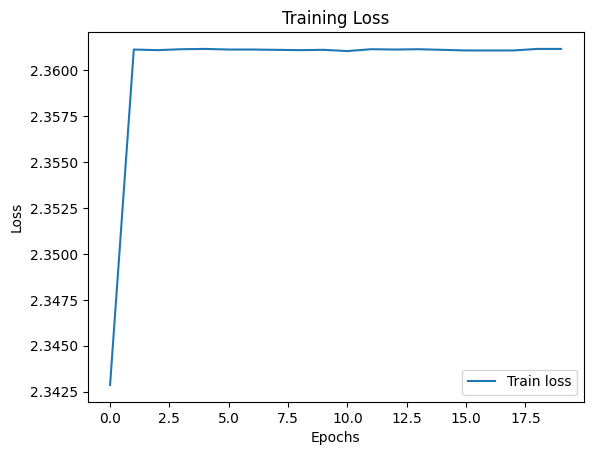

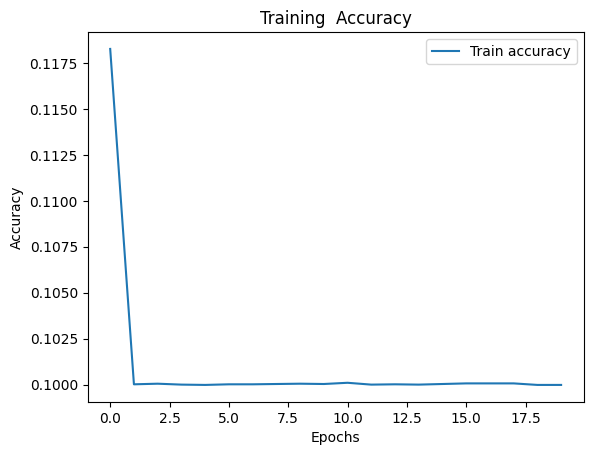

In [ ]:
epochs = range(num_epochs)

plt.plot(epochs, list_loss, label='Train loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.plot(epochs, list_accuracy, label='Train accuracy')
plt.title('Training  Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
y_pred, y_true = predict(model, test_loader)

In [ ]:
acc, f1, precision, recall = compute_score(y_pred, y_true)
print("Accuracy: {:.2f}".format(acc), end=" | ")
print("F1 Score: {:.2f}".format(f1), end=" | ")
print("Precision: {:.2f}".format(precision), end=" | ")
print("Recall: {:.2f}".format(recall))

Accuracy: 0.10 | F1 Score: 0.02 | Precision: 0.86 | Recall: 0.10


In [ ]:
metrics = classification_labels(y_pred, y_true)
print(f'{"Class":<5} {"F1-score":<10} {"Accuracy":<10} {"Precision":<10} {"Recall":<10}')

for i in range(len(metrics['f1'])):
  print(f'{i:<5} {metrics["f1"][i].item():<10.4f} {metrics["accuracy"][i].item():<10.4f} {metrics["precision"][i].item():<10.4f} {metrics["recall"][i].item():<10.4f}')

Class F1-score   Accuracy   Precision  Recall    
0     nan        0.0000     nan        0.0000    
1     nan        0.0000     nan        0.0000    
2     nan        0.0000     nan        0.0000    
3     0.1819     1.0000     0.1000     1.0000    
4     nan        0.0000     nan        0.0000    
5     nan        0.0000     nan        0.0000    
6     nan        0.0000     nan        0.0000    
7     nan        0.0000     nan        0.0000    
8     0.0020     0.0010     0.5000     0.0010    
9     nan        0.0000     nan        0.0000    


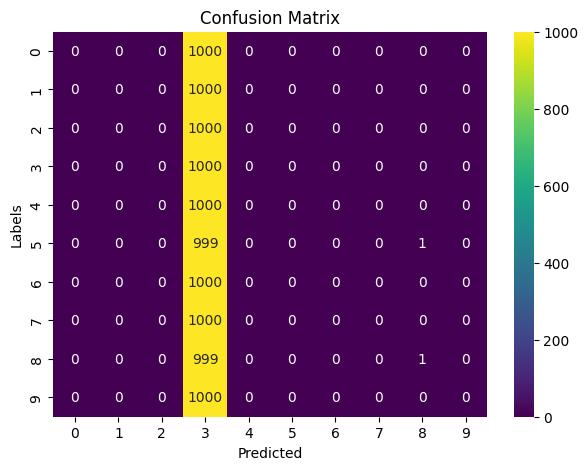

In [ ]:
show_confusion_matrix(y_pred, y_true)

**Nhận Xét:**
* Với hàm tối ưu RMSProp mô hình dự đoán chỉ nằm ở một nhãn có thể thấy mô hình với hàm tối ưu RMSProp chưa tốt và phù hợp với bài toán.
* Chỉ có lớp 3 và 8 có giá trị dự đoán đúng, nhưng không phản ánh hiệu suất tốt của mô hình.
* Dựa vào training loss và acc có thể thấy loss lại tăng qua từng epochs và acc giảm nên có thể thấy mô hình chưa học được qua từng epochs. Có thể thấy hàm tối ưu này chưa thật sự phù hợp.

### Hàm tối ưu Adam với learning rate = $10^{-5}$

In [ ]:
model = ModelC().to(device)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr = learning_rate_adam)

In [ ]:
loss_fn = nn.CrossEntropyLoss()

list_loss = []
list_accuracy = []

for epoch in range(num_epochs):
    epoch_loss = 0.0
    epoch_acc = 0.0

    with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
        for i, (images, labels) in enumerate(train_loader):
            # forward backward, update
            images = images.to(device)
            labels = labels.to(device)
            # Forward pass
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            acc = (torch.max(outputs, dim=1)[1] == labels).sum().item() / labels.size(0)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            epoch_acc += acc

            pbar.set_postfix({'Loss': f'{epoch_loss / (i+1):.4f}', 'Accuracy': f'{epoch_acc / (i+1):.4f}'})
            pbar.update()

    epoch_loss /= len(train_loader)
    epoch_acc /= len(train_loader)
    list_loss.append(epoch_loss)
    list_accuracy.append(epoch_acc)

Epoch 1/20:   0%|          | 0/938 [00:00<?, ?batch/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Epoch 20/20: 100%|██████████| 938/938 [00:27<00:00, 33.60batch/s, Loss=1.6065, Accuracy=0.8626]


#### Đánh giá mô hình

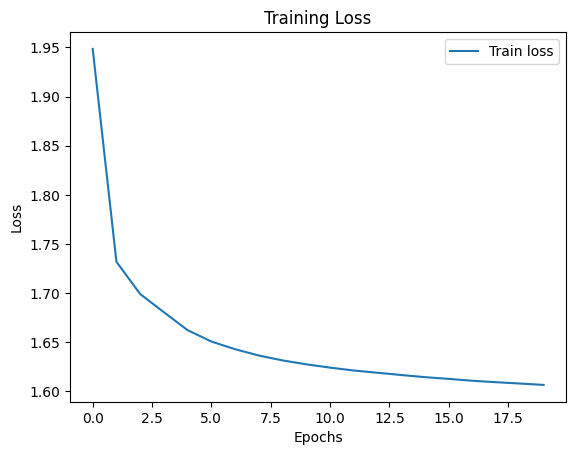

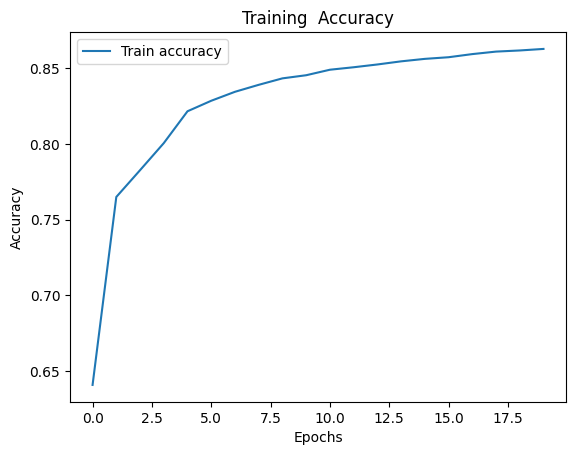

In [ ]:
epochs = range(num_epochs)

plt.plot(epochs, list_loss, label='Train loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.plot(epochs, list_accuracy, label='Train accuracy')
plt.title('Training  Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
y_pred, y_true = predict(model, test_loader)

In [ ]:
acc, f1, precision, recall = compute_score(y_pred, y_true)
print("Accuracy: {:.2f}".format(acc), end=" | ")
print("F1 Score: {:.2f}".format(f1), end=" | ")
print("Precision: {:.2f}".format(precision), end=" | ")
print("Recall: {:.2f}".format(recall))

Accuracy: 0.85 | F1 Score: 0.84 | Precision: 0.85 | Recall: 0.85


In [ ]:
metrics = classification_labels(y_pred, y_true)
print(f'{"Class":<5} {"F1-score":<10} {"Accuracy":<10} {"Precision":<10} {"Recall":<10}')

for i in range(len(metrics['f1'])):
  print(f'{i:<5} {metrics["f1"][i].item():<10.4f} {metrics["accuracy"][i].item():<10.4f} {metrics["precision"][i].item():<10.4f} {metrics["recall"][i].item():<10.4f}')

Class F1-score   Accuracy   Precision  Recall    
0     0.8056     0.8350     0.7782     0.8350    
1     0.9654     0.9480     0.9834     0.9480    
2     0.7591     0.7830     0.7366     0.7830    
3     0.8462     0.8940     0.8032     0.8940    
4     0.7628     0.7830     0.7436     0.7830    
5     0.9329     0.9170     0.9493     0.9170    
6     0.5814     0.4910     0.7126     0.4910    
7     0.9134     0.9280     0.8992     0.9280    
8     0.9440     0.9610     0.9276     0.9610    
9     0.9359     0.9410     0.9308     0.9410    


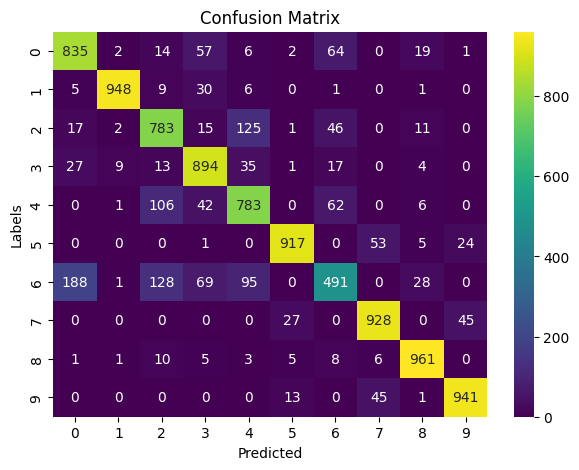

In [ ]:
show_confusion_matrix(y_pred, y_true)

**Nhận Xét:**
*  So với hàm tối ưu RMSProp ở trên có thể thấy tối ưu bằng Adam tối ưu hơn và phù hợp hơn so với bài toán.
*   Biểu đồ loss và acc ổn định hơn so nhiều khi tối ưu với dùng hàm tối ưu RMSProp.

